Copyright (c) 2022 Valentin Hartmann. All rights reserved.  
Released under Apache 2.0 license as described in the file LICENSE.

In [1]:
import math
import scipy.integrate as integrate
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

# SVT

Our goal in this section is to demonstrate the advantage of using ODP analysis over standard DP analysis for releasing a sparse vector via SVT. We consider a 100-dimensional vector and want to release the indices and values of those entries whose absolute value lies above the threshold $T=500$. For more details see Sec. 4.1 of the paper.

We start by defining some constants.

In [2]:
Delta = 1
c = 20
eps_1_plus_eps_2 = 0.5
eps_3 = 0.5

For computing the optimal $\varepsilon_1,\varepsilon_2$ for a total budget of $\alpha = \varepsilon_1 + \varepsilon_2$ we solve the system of equations
$$
\begin{align}
\varepsilon_1+\varepsilon_2 &= \alpha\\
\frac{\varepsilon_1}{\varepsilon_2} &= \frac{1}{(2c)^{2/3}}.
\end{align}
$$
We get
$$
\begin{align}
\varepsilon_1 &= \frac{1}{1+\frac{1}{(2c)^{2/3}}} \frac{1}{(2c)^{2/3}} \alpha\\
\varepsilon_2 &= \alpha - \varepsilon_1.
\end{align}
$$

In [3]:
def split_budget_eps_1_2(budget, c):
    eps_1 = (1/(1+(1/math.pow(2*c, 2/3)))) * (1/math.pow(2*c,2/3)) * budget
    eps_2 = budget - eps_1
    return eps_1, eps_2

Setting $\alpha=0.5$ and $c=20$ yields:

In [4]:
eps_1, eps_2 = split_budget_eps_1_2(eps_1_plus_eps_2, c)
print(f'epsilon_1 = {eps_1}, epsilon_2 = {eps_2}')

epsilon_1 = 0.039382262580038824, epsilon_2 = 0.46061773741996115


For computing the expected noise added with an ODP analysis we need to compute the expected number of released vector entries. For this we need the probability $\mathbb{P}(\nu_i - \rho \geq T_i - q_i(\mathbf{x}))$ that a given entry is released.
We have $\rho \sim \text{Lap}(\Delta/\varepsilon_1)$ and $\nu_i \sim \text{Lap}(2c\Delta/\varepsilon_2)$. Since the distribution of $\rho$ is symmetric around 0, $\nu_i - \rho$ follows the same distribution as $\nu_i + \rho$. Letting $b_1 = \Delta/\varepsilon_1$ and $b_2 = 2c\Delta/\varepsilon_2$, we need to integrate over the convolution of the two Laplace distributions:
$$
\mathbb{P}(\nu_i - \rho \geq T_i - q_i(\mathbf{x})) = \int_{T_i - q_i(\mathbf{x})}^{\infty} \int_{-\infty}^{\infty} \frac{1}{2b_1} \exp\left(-\frac{|\rho|}{b_1}\right) \frac{1}{2b_2} \exp\left(-\frac{|\nu - \rho|}{b_2}\right) d\rho d\nu.
$$

We compute $b_1$ and $b_2$:

In [5]:
def compute_b_1(Delta, eps_1):
    return Delta / eps_1

In [6]:
def compute_b_2(c, Delta, eps_2):
    return 2*c*Delta / eps_2

In [7]:
b_1 = compute_b_1(Delta, eps_1)
b_2 = compute_b_2(c, Delta, eps_2)
print(f'b_1 = {b_1}, b_2 = {b_2}')

b_1 = 25.392141905702925, b_2 = 86.8399037867068


Now we can (numerically) compute the above integral. We consider $T_i=500$ and for the values of $q_i(\mathbf{x})$ only the cases 0 and 1000. Let
$$
p_0(1) = \mathbb{P}(\nu_i - \rho \geq 500),\quad p_0(0) = 1 - p_0(1)
$$
and
$$
p_{1000}(1) = \mathbb{P}(\nu_i - \rho \geq -500),\quad p_{1000}(0) = 1 - p_{1000}(1)
$$
be the four probabilities that we are interested in.
Due to the symmetry of the Laplace distribution we can further simplify $p_{1000}(1)$ as
$$
p_{1000}(1) = 1 - p_0(1).
$$

In [8]:
def integrand_all_args(b_1, b_2, rho, nu):
    fraction = 1 / (4*b_1*b_2)
    power = (-abs(rho)/b_1) - (abs(nu-rho)/b_2)
    return fraction * np.exp(power)

In [9]:
integrand = lambda rho, nu: integrand_all_args(b_1, b_2, rho, nu)

In [10]:
p_0_1, error_0_1 = integrate.dblquad(integrand, 500, np.inf, lambda nu: -np.inf, lambda nu: np.inf)
print(f'p_0(1) = {p_0_1}, error = {error_0_1}')

p_0(1) = 0.0017267930924315283, error = 1.484769393467497e-08


In [11]:
p_1000_1 = 1 - p_0_1

Let $n$ be the total number of queries (in our case 100), and let $n_0$, $n_{1000}$ be the numbers of queries with $q_i(\mathbf{x}) = 0$ and $q_i(\mathbf{x}) = 1000$, respectively. Let $X_0 \sim \text{Bin}(n_0,p_0(1))$, $X_{1000} \sim \text{Bin}(n_{1000},p_{1000}(1))$ be binomial distributions with $n_0$ trials and $n_{1000}$ trials, respectively and success probabilities $p_0(1)$ and $p_{1000}(1)$, respectively. Then the number of queries that pass the test is
$$
S = X_0 + X_{1000}.
$$
Even if $n_{1000}\leq c$ as in our example, it can still happen that more than $n_{1000}$ queries pass the test in line 7 of the SVT algorithm due its randomness. But even with ODP we never release more than $c$ entries. Thus the expected number of released vector entries is
$$
\mathbb{E}(\min(S,c)) = \sum_{m=0}^{c-1} [m \mathbb{P}(S=m)] + \sum_{m=c}^n [c \mathbb{P}(S=m)].
$$
We can compute $\mathbb{P}(S=m)$ via the following convolution:
$$
\mathbb{P}(S=m) = \sum_{k=0}^{n_0} \mathbb{P}(X_0=k) \mathbb{P}(X_{1000}=m-k).
$$

In [12]:
def compute_prob_S_equals_m(n_0, n_1000, p_0_1, p_1000_1, m):
    prob = 0
    for k in range(n_0+1):
        prob += stats.binom.pmf(k, n_0, p_0_1) * stats.binom.pmf(m-k, n_1000, p_1000_1)
    return prob

In [13]:
def compute_expectation_min_S_c(n_0, n_1000, p_0_1, p_1000_1, c):
    n = n_0 + n_1000
    expectation = 0
    for m in range(c):
        expectation += m * compute_prob_S_equals_m(n_0, n_1000, p_0_1, p_1000_1, m)
    for m in range(c, n+1):
        expectation += c * compute_prob_S_equals_m(n_0, n_1000, p_0_1, p_1000_1, m)
    return expectation

We are now able to compute the expectations for the different numbers of large entries that we want to consider.

In [14]:
n = 100
n_1000_s = range(20+1)

In [15]:
expected_nums_outputs_odp = [compute_expectation_min_S_c(n-n_1000, n_1000, p_0_1, p_1000_1, c) for n_1000 in n_1000_s]

It remains to compute the privacy budget that is remaining for the release of the vector entries and from that the required noise per entry.

In the non-ODP case we have a budget of
$$
\frac{\varepsilon_3}{c}
$$ per entry.

Let $c'$ be the number of released entries. Then in the ODP case we have a budget of
$$
\frac{1}{c'}\left(\varepsilon_3 + \frac{c-c'}{c}\varepsilon_2\right)
$$
per entry.

For a given per-entry budget $\varepsilon$, the standard deviation of the added Laplace noise is
$$
\sqrt{2}\frac{\Delta}{\varepsilon}.
$$

In [16]:
def non_odp_eps_per_entry(eps_3, c):
    return eps_3 / c

In [17]:
def expected_odp_eps_per_entry(n, eps_2, eps_3, c, c_prime):
    expected_eps = eps_3 + ((c-c_prime)/c)*eps_2
    expected_eps /= c_prime
    return expected_eps

In [18]:
def std_dev_laplace(Delta, eps):
    return math.sqrt(2) * Delta / eps

In [19]:
non_odp_std_dev = std_dev_laplace(Delta, non_odp_eps_per_entry(eps_3, c))

odp_eps_s = [expected_odp_eps_per_entry(n, eps_2, eps_3, c, c_prime) for c_prime in expected_nums_outputs_odp]
odp_std_dev_s = [std_dev_laplace(Delta, eps) for eps in odp_eps_s]

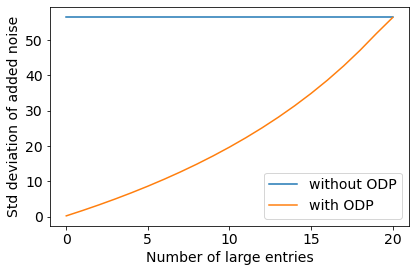

In [20]:
plt.plot(range(0,21), np.ones(21)*non_odp_std_dev, label='without ODP')
plt.plot(range(0,21), odp_std_dev_s, label='with ODP')
plt.xlabel('Number of large entries')
plt.ylabel('Std deviation of added noise')
plt.legend()
plt.tight_layout()
plt.savefig('svt.pdf')

# ERM

In this section we investigate the ODP variant of output perturbation for releasing a noisy logistic regression model, but only it its error lies below a given threshold. We compute the amount of noise that needs to be added to the error before the comparison with the threshold. For more details see Sec. 6.1 of the paper.

We start by computing $a$ from line 2 of Alg. 5.

In [21]:
def compute_a(n_train, n_test, Lambda):
    return max(2/n_test, 2*(np.exp(2/(n_train*Lambda)) - 1))

We want to plot the 95-th percentile of the noise added to the model error.

In [22]:
def score_noise_quantile(a, epsilon_2, F):
    '''
    Computes the F-quantile of the noise added to the model error.
    F must be >= 1/2.
    '''
    
    laplace_param = a/epsilon_2
    return -laplace_param * np.log(2-2*F)

We define the different settings that we consider. In all settings 70% of the data is used for training and 30% is used for testing.

In [23]:
epsilons_2_s = [0.1, 0.2, 0.5]
dataset_sizes = range(1000, 5000)
fraction_test = 0.3 # fraction of test records
Lambda = 1
quantile = 0.95

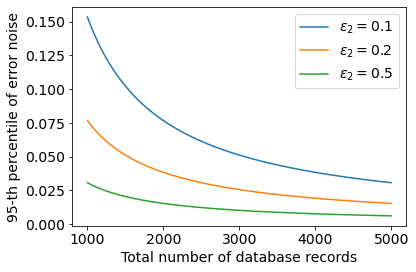

In [24]:
for epsilon_2 in epsilons_2_s:
    percentiles = [score_noise_quantile(compute_a((1-fraction_test)*size, fraction_test*size, Lambda), epsilon_2, quantile)
                   for size in dataset_sizes]
    plt.plot(dataset_sizes, percentiles, label=f'$\\varepsilon_2={epsilon_2}$')

plt.ylabel('95-th percentile of error noise')
plt.xlabel('Total number of database records')
plt.legend()
plt.tight_layout()
plt.savefig('erm.pdf')